In [1]:
import requests

import json
import os

import pandas as pd

import sys, traceback
import mwreverts.api
import mwapi

# We'll use the mwreverts API check.  In order to do that, we need an API session
session = mwapi.Session("https://en.wikipedia.org", 
                        user_agent="Max Klein Newcomer Quality <max@notconfusing.com>")

import datetime as dt


from collections import defaultdict

from sklearn_pandas import DataFrameMapper, cross_val_score


import pandas as pd
pd.set_option('display.max_colwidth', 250)
import numpy as np
import sklearn.preprocessing, sklearn.linear_model, sklearn.metrics, sklearn.ensemble
import sklearn.model_selection


In [10]:
endpoint = 'https://labels.wmflabs.org/campaigns/'

resp = requests.get(url=endpoint)
data = resp.json()

wikis = data['wikis']

mdtp_campaigns = {}

mdtp_tasks = {}

In [11]:
for wiki in wikis:
    wiki_endpoint = f'{endpoint}{wiki}'
#     print(wiki_endpoint)
    wiki_resp = requests.get(wiki_endpoint)
    wiki_data = wiki_resp.json()
    for campaign in wiki_data['campaigns']:
        if campaign['view'] == 'MultiDiffToPrevious':
            mdtp_campaigns[wiki] = campaign['id']

In [12]:
for k, v in mdtp_campaigns.items():
    campaign_endpoint = f'{endpoint}{k}/{v}/?tasks'
    print(campaign_endpoint)
    campaign_resp = requests.get(campaign_endpoint)
    campaign_data = campaign_resp.json()
    mdtp_tasks[k] = campaign_data['tasks']


for wiki, tasks in mdtp_tasks.items():
    print(f'wiki:{wiki}')
    completed = [t for t in tasks if t['labels']]
    with open('enwiki_newcomer_labelled_100.jsonl','w') as outf:
        for l in completed:
            rev_ids = l['data']['rev_ids']
            labels = l['labels'][0]['data']
            id_labels = {'rev_ids':rev_ids, **labels}
            outf.write(json.dumps(id_labels))
            outf.write('\n')
    print(f'{len(completed)} completed tasks of {len(tasks)} total')
#     for task in tasks:
#         lab = task['labels']
#         if lab:
#             print(lab)

https://labels.wmflabs.org/campaigns/enwiki/86/?tasks
wiki:enwiki
436 completed tasks of 1989 total


# Check the singletons

In [13]:
def perc_singleton(fname):
    rev_lens = []
    with open(fname,'r') as f:
        for line in f:
            d = json.loads(line)
            rev_ids  = d['rev_ids']
            rev_lens.append(len(rev_ids))

    num_singleton = len([l for l in rev_lens if l==1])
    perc_singleton =  num_singleton / len(rev_lens)
    return num_singleton, perc_singleton

In [14]:
jsonls = [f for f in os.listdir('.') if f.endswith('.jsonl')]
for jsonl in jsonls:
    print(jsonl, perc_singleton(jsonl))

enwiki_newcomer_labelled_100.jsonl (221, 0.5068807339449541)


# Get ORES data

In [15]:
completed_row_oriented = [{'task_id': c['id'],
                            'user_id':c['data']['user_id'],
                           'rev_ids':c['data']['rev_ids'],
                           'damaging_label':c['labels'][0]['data']['damaging'],
                           'goodfaith_label':c['labels'][0]['data']['goodfaith'],} for c in completed]

In [16]:
df = pd.DataFrame.from_dict(completed_row_oriented)

In [17]:
df = df[pd.notnull(df['goodfaith_label']) & pd.notnull(df['damaging_label'])] #no skipped ones

In [18]:
ores_string = 'https://ores.wikimedia.org/v3/scores/{context}/{revid}/{model}'
context = 'enwiki'
models = ('damaging', 'goodfaith')

In [24]:
def get_ores_data_dgf(rev_ids):
#     print(f'getting {len(rev_ids)} revs')
    ores_data = {}
    for model in ('damaging', 'goodfaith'):
        ores_data[model] = []
        for rev_id in rev_ids:
            ores_req = ores_string.format(context=context, revid=rev_id, model=model)
            ores_resp = requests.get(url=ores_req)
            json_data = ores_resp.json()
            try:
                ores_datum_raw = json_data[context]['scores'][str(rev_id)][model]['score']
                ores_datum = {'prediction':ores_datum_raw['prediction'],'prob_true':ores_datum_raw['probability']['true']}
                ores_data[model].append(ores_datum)
            except KeyError:
                ores_data[model].append(float('nan'))
    return ores_data

In [20]:
sdf = df[:10]

In [21]:
%time sdf['ores_data'] = sdf['rev_ids'].apply(get_ores_data_dgf)

getting 1 revs
getting 5 revs
getting 4 revs
getting 1 revs
getting 1 revs
getting 4 revs
getting 1 revs
getting 1 revs
getting 1 revs
getting 3 revs
CPU times: user 941 ms, sys: 60 ms, total: 1 s
Wall time: 20.6 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
sdf.iloc[1]['ores_data']

{'damaging': [{'prediction': False, 'prob_true': 0.09601118263157825},
  {'prediction': False, 'prob_true': 0.23005538799402592},
  {'prediction': False, 'prob_true': 0.3725931153402145},
  {'prediction': False, 'prob_true': 0.2364148442188683},
  {'prediction': False, 'prob_true': 0.3605051146114929}],
 'goodfaith': [{'prediction': True, 'prob_true': 0.9829427927492975},
  {'prediction': True, 'prob_true': 0.9641269434220542},
  {'prediction': True, 'prob_true': 0.9637834671582234},
  {'prediction': True, 'prob_true': 0.8775891764561563},
  {'prediction': True, 'prob_true': 0.9341377634684186}]}

In [25]:
df['ores_data'] = df['rev_ids'].apply(get_ores_data_dgf)


In [26]:
df.to_pickle('/home/paprika/workspace/wikilabels_data/saves/exp_v1_with_ores_scores.pickle')

df = pd.read_pickle('/home/paprika/workspace/wikilabels_data/saves/exp_v1_with_ores_scores.pickle')

In [27]:
df.head()

,damaging_label,goodfaith_label,rev_ids,task_id,user_id,ores_data
0,False,True,[764113608],558731,30282906,"{'damaging': [{'prediction': False, 'prob_true': 0.15501228732476371}], 'goodfaith': [{'prediction': True, 'prob_true': 0.976423405666497}]}"
1,False,True,"[763924694, 763926307, 763930716, 763931301, 763932010]",558733,30282911,"{'damaging': [{'prediction': False, 'prob_true': 0.09601118263157825}, {'prediction': False, 'prob_true': 0.23005538799402592}, {'prediction': False, 'prob_true': 0.3725931153402145}, {'prediction': False, 'prob_true': 0.2364148442188683}, {'pred..."
2,False,True,"[764251399, 764252150, 764253295, 764257845]",558734,30282911,"{'damaging': [{'prediction': False, 'prob_true': 0.04356904152227608}, {'prediction': False, 'prob_true': 0.4499425384549236}, {'prediction': False, 'prob_true': 0.22013728098376725}, {'prediction': False, 'prob_true': 0.06750852803308395}], 'goo..."
3,False,True,[763918492],558737,30282924,"{'damaging': [{'prediction': True, 'prob_true': 0.6152127780999527}], 'goodfaith': [{'prediction': True, 'prob_true': 0.5972110083906026}]}"
4,False,True,[763917983],558741,30282943,"{'damaging': [{'prediction': False, 'prob_true': 0.27870679674580473}], 'goodfaith': [{'prediction': True, 'prob_true': 0.8745512035659346}]}"


In [28]:
df['damaging_scores'] = df['ores_data'].apply(lambda d: [e['prob_true'] for e in d['damaging'] if isinstance(e, dict)])
df['goodfaith_scores'] = df['ores_data'].apply(lambda d: [e['prob_true'] for e in d['goodfaith'] if isinstance(e, dict)])
df['damaging_predictions'] = df['ores_data'].apply(lambda d: [e['prediction'] for e in d['damaging'] if isinstance(e, dict)])
df['goodfaith_predictions'] = df['ores_data'].apply(lambda d: [e['prediction'] for e in d['goodfaith'] if isinstance(e, dict)])

In [29]:
df = df[df['damaging_scores'].apply(lambda l:len(l)>0)] # drop out nan results

In [30]:
df['goodfaith_session_edit_mismatch'] = df[['goodfaith_label','goodfaith_predictions']].apply(lambda row: not(row['goodfaith_label'] in row['goodfaith_predictions']), axis=1)
df['damaging_session_edit_mismatch'] = df[['damaging_label','damaging_predictions']].apply(lambda row: not(row['damaging_label'] in row['damaging_predictions']), axis=1)

In [31]:
goodfaith_mismatches = df[df['goodfaith_session_edit_mismatch']==True]
damaging_mismatches = df[df['damaging_session_edit_mismatch']==True]

In [32]:
print(f'len goodfaith mistmatches: {len(goodfaith_mismatches)}')
print(f'len damaging mistmatches: {len(damaging_mismatches)}')

len goodfaith mistmatches: 59
len damaging mistmatches: 80


In [322]:
def wlink(rev_id):
    return f'https://en.wikipedia.org/w/index.php?diff=prev&oldid={rev_id}&diffmode=source'

In [323]:
goodfaith_mismatches['wlinks'] = goodfaith_mismatches['rev_ids'].apply(lambda rl: [wlink(r) for r in rl])
damaging_mismatches['wlinks'] = damaging_mismatches['rev_ids'].apply(lambda rl: [wlink(r) for r in rl])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [324]:
goodfaith_mismatches[goodfaith_mismatches['rev_ids'].apply(lambda l:len(l)>1)]

,damaging_label,goodfaith_label,rev_ids,task_id,user_id,ores_data,damaging_scores,goodfaith_scores,damaging_predictions,goodfaith_predictions,goodfaith_session_edit_mismatch,damaging_session_edit_mismatch,wlinks
25,True,False,"[763926298, 763926606]",558838,30283258,"{'damaging': [{'prediction': False, 'prob_true': 0.4730587747991271}, {'prediction': True, 'prob_true': 0.7440500123958258}], 'goodfaith': [{'prediction': True, 'prob_true': 0.6616573843599153}, {'prediction': True, 'prob_true': 0.575930360909807...","[0.4730587747991271, 0.7440500123958258]","[0.6616573843599153, 0.5759303609098076]","[False, True]","[True, True]",True,False,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763926298&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763926606&diffmode=source]"
29,True,True,"[763929270, 763930145]",558858,30283361,"{'damaging': [{'prediction': True, 'prob_true': 0.7183727092044194}, {'prediction': True, 'prob_true': 0.8418168665142072}], 'goodfaith': [{'prediction': False, 'prob_true': 0.372561553827677}, {'prediction': False, 'prob_true': 0.319276701933801...","[0.7183727092044194, 0.8418168665142072]","[0.372561553827677, 0.3192767019338014]","[True, True]","[False, False]",True,False,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763929270&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763930145&diffmode=source]"
34,True,False,"[763931594, 763931748, 763931985, 763932104, 763932276, 763932378, 763932518, 763932758, 763932820, 763932978, 763933076, 763933123]",558873,30283433,"{'damaging': [{'prediction': False, 'prob_true': 0.04855927009982969}, {'prediction': False, 'prob_true': 0.04827772144830002}, {'prediction': False, 'prob_true': 0.047270077026541145}, {'prediction': False, 'prob_true': 0.03892583587509084}, {'p...","[0.04855927009982969, 0.04827772144830002, 0.047270077026541145, 0.03892583587509084, 0.03530222554171994, 0.03530222554171994, 0.03530222554171994, 0.03422691310387431, 0.03422691310387431, 0.033474584319137586, 0.033474584319137586, 0.033474584...","[0.9746022472848997, 0.9755450130495057, 0.9766892085100262, 0.978706851093428, 0.978252465812957, 0.978252465812957, 0.9781831673783714, 0.9802579909246855, 0.9802579909246855, 0.9802010540068654, 0.9806229940439372, 0.9806229940439372]","[False, False, False, False, False, False, False, False, False, False, False, False]","[True, True, True, True, True, True, True, True, True, True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931594&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931748&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931985&diffmode=source, https..."
39,True,False,"[763948318, 763948569, 763948921]",558882,30283483,"{'damaging': [{'prediction': False, 'prob_true': 0.051086111591214456}, {'prediction': False, 'prob_true': 0.33772422341948266}, {'prediction': False, 'prob_true': 0.08932391658798042}], 'goodfaith': [{'prediction': True, 'prob_true': 0.985714294...","[0.051086111591214456, 0.33772422341948266, 0.08932391658798042]","[0.9857142949465324, 0.9208009878954571, 0.9803447840612858]","[False, False, False]","[True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948318&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948569&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948921&diffmode=source]"
47,True,False,"[763945255, 763945337, 763947098, 763947299, 763947374]",558920,30283679,"{'damaging': [{'prediction': False, 'prob_true': 0.020456219200129168}, {'prediction': False, 'prob_true': 0.02267604719777314}, {'prediction': False, 'prob_true': 0.01743717378388933}, {'prediction': False, 'prob_true': 0.17915060506395433}, {'p...","[0.020456219200129168, 0.02267604719777314, 0.01743717378388933, 0.17915060506395433, 0.22398155772394754]","[0.9867851652787335, 0.9840186467666154, 0.9851928298489351, 0.9

In [325]:
damaging_mismatches[damaging_mismatches['rev_ids'].apply(lambda l:len(l)>1)]

,damaging_label,goodfaith_label,rev_ids,task_id,user_id,ores_data,damaging_scores,goodfaith_scores,damaging_predictions,goodfaith_predictions,goodfaith_session_edit_mismatch,damaging_session_edit_mismatch,wlinks
34,True,False,"[763931594, 763931748, 763931985, 763932104, 763932276, 763932378, 763932518, 763932758, 763932820, 763932978, 763933076, 763933123]",558873,30283433,"{'damaging': [{'prediction': False, 'prob_true': 0.04855927009982969}, {'prediction': False, 'prob_true': 0.04827772144830002}, {'prediction': False, 'prob_true': 0.047270077026541145}, {'prediction': False, 'prob_true': 0.03892583587509084}, {'p...","[0.04855927009982969, 0.04827772144830002, 0.047270077026541145, 0.03892583587509084, 0.03530222554171994, 0.03530222554171994, 0.03530222554171994, 0.03422691310387431, 0.03422691310387431, 0.033474584319137586, 0.033474584319137586, 0.033474584...","[0.9746022472848997, 0.9755450130495057, 0.9766892085100262, 0.978706851093428, 0.978252465812957, 0.978252465812957, 0.9781831673783714, 0.9802579909246855, 0.9802579909246855, 0.9802010540068654, 0.9806229940439372, 0.9806229940439372]","[False, False, False, False, False, False, False, False, False, False, False, False]","[True, True, True, True, True, True, True, True, True, True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931594&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931748&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763931985&diffmode=source, https..."
39,True,False,"[763948318, 763948569, 763948921]",558882,30283483,"{'damaging': [{'prediction': False, 'prob_true': 0.051086111591214456}, {'prediction': False, 'prob_true': 0.33772422341948266}, {'prediction': False, 'prob_true': 0.08932391658798042}], 'goodfaith': [{'prediction': True, 'prob_true': 0.985714294...","[0.051086111591214456, 0.33772422341948266, 0.08932391658798042]","[0.9857142949465324, 0.9208009878954571, 0.9803447840612858]","[False, False, False]","[True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948318&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948569&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763948921&diffmode=source]"
43,False,False,"[763934049, 763934196, 763934324]",558894,30283552,"{'damaging': [{'prediction': True, 'prob_true': 0.7762776688360993}, {'prediction': True, 'prob_true': 0.6276607010744235}, {'prediction': True, 'prob_true': 0.7407605345081835}], 'goodfaith': [{'prediction': False, 'prob_true': 0.291930650099069...","[0.7762776688360993, 0.6276607010744235, 0.7407605345081835]","[0.2919306500990693, 0.5073118633667208, 0.4407799468961656]","[True, True, True]","[False, True, False]",False,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763934049&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763934196&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763934324&diffmode=source]"
47,True,False,"[763945255, 763945337, 763947098, 763947299, 763947374]",558920,30283679,"{'damaging': [{'prediction': False, 'prob_true': 0.020456219200129168}, {'prediction': False, 'prob_true': 0.02267604719777314}, {'prediction': False, 'prob_true': 0.01743717378388933}, {'prediction': False, 'prob_true': 0.17915060506395433}, {'p...","[0.020456219200129168, 0.02267604719777314, 0.01743717378388933, 0.17915060506395433, 0.22398155772394754]","[0.9867851652787335, 0.9840186467666154, 0.9851928298489351, 0.9097528002582813, 0.8942124644148761]","[False, False, False, False, False]","[True, True, True, True, True]",True,True,"[https://en.wikipedia.org/w/index.php?diff=prev&oldid=763945255&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763945337&diffmode=source, https://en.wikipedia.org/w/index.php?diff=prev&oldid=763947098&diffmode=source, https..."
80,True,False,"[764004719, 764006056]",559073,30284320,"{'damaging': [{'predictio

# TODO:Try a new label where the singletons are just the ores label

##  Get timestamps #

In [33]:
def get_rev_timestamps(revids):
    timestamps = []
    pages = []
    if len(revids)>50:
        print('truncating to 50 revids')
        revids=revids[:49]
    rev_query = session.get(action='query', prop='revisions', revids=revids)
    for page_id, page_info in rev_query['query']['pages'].items():
        page = {'page_id':page_id, 'page_ns':page_info['ns']}
        pages.append(page)
        revisions = page_info['revisions']
        for revision in revisions:
#             print(revision)
            timestamp = dt.datetime.strptime(revision['timestamp'],  "%Y-%m-%dT%H:%M:%SZ")
            timestamps.append(timestamp)
    return {'timestamps':timestamps, 'pages':pages}

In [34]:
df['timestamps_pages'] = df['rev_ids'].apply(lambda x: get_rev_timestamps(x))

truncating to 50 revids


In [35]:
df['timestamps'] = df['timestamps_pages'].apply(lambda d: d['timestamps'])
df['pages'] = df['timestamps_pages'].apply(lambda d: d['pages'])

In [329]:
df.to_pickle('saves/exp_v2_with_ores_scores.pickle')

df = pd.read_pickle('saves/exp_v2_with_ores_scores.pickle')

In [36]:
def num_reverts(revids):
    self_reverts = 0
    reverting_users = defaultdict(int)
    for rev_id in revids:
        try:
            _, reverted, reverted_to = mwreverts.api.check(
                session, rev_id, radius=2,  # most reverts within 5 edits
                window=48*60*60,  # 2 days
                rvprop={'user', 'ids'})  # Some properties we'll make use of
        except (RuntimeError, KeyError) as e:
            sys.stderr.write(str(e))
            continue
            
        if reverted is not None:
            
            reverting_user = reverted.reverting['user']
            reverting_users[reverting_user] += 1
            
            reverted_doc = [r for r in reverted.reverteds
                            if r['revid'] == rev_id][0]

            if 'user' not in reverted_doc or 'user' not in reverted.reverting:
                continue

            # self-reverts
            self_revert = \
                reverted_doc['user'] == reverting_user

            if self_revert:
                self_reverts += 1
    
    edit_war_users = [user for user, num_reverts in reverting_users.items() if num_reverts > 1]
    edit_wars = len(edit_war_users)
    
    return {'self_reverts': self_reverts, 'edit_wars':edit_wars}

In [37]:
df['revert_data'] = df['rev_ids'].apply(lambda x: num_reverts(x))

df['self_reverts'] = df['revert_data'].apply(lambda d: d['self_reverts'])
df['edit_wars'] = df['revert_data'].apply(lambda d: d['edit_wars'])

In [39]:
df['self_reverts'].value_counts()

0    411
1      8
5      1
Name: self_reverts, dtype: int64

In [40]:
df['edit_wars'].value_counts()

0    375
1     39
2      5
3      1
Name: edit_wars, dtype: int64

In [335]:
df.to_pickle('saves/exp_v3_with_ores_scores.pickle')

df = pd.read_pickle('saves/exp_v3_with_ores_scores.pickle')

# Class Priors

In [41]:
df['goodfaith_label'].sum() / len(df)

0.7428571428571429

In [42]:
df['damaging_label'].sum() / len(df)

0.39285714285714285


# Feature Engineering

## simple
+ mean scores, max scores, min scores, var scores, trend-line score, count scores

## temporal
+ total time, 

## added subtracted
+ total added, total subtracted, count additions, count subtractions, 

## self-reverts
+ self-reverts

In [43]:
# First do goodfaith
# the interesting part is where goodfaith session doesn't agree with goodfaith edits

In [44]:
np.polyfit([0,1],[0,2],1)

array([2.00000000e+00, 3.16375741e-17])

In [45]:
list(range(len([1,2])))

[0, 1]

In [46]:
def simp_lin_reg(vec,slope_intercept='slope'):
    if len(vec)==1:
        return 0
    else:
        x=list(range(len(vec)))
        reg = np.polyfit(x,vec,1)
        return reg[0] if slope_intercept == 'slope' else reg[1]

In [47]:
df['goodfaith_label_bin'] = df['goodfaith_label'].apply(lambda x: int(x))
df['damaging_label_bin'] = df['damaging_label'].apply(lambda x: int(x))

In [48]:
df['damaging_scores_mean'] = df['damaging_scores'].apply(np.mean)
df['damaging_scores_var'] = df['damaging_scores'].apply(np.var)
df['damaging_scores_max'] = df['damaging_scores'].apply(max)
df['damaging_scores_min'] = df['damaging_scores'].apply(min)
df['damaging_scores_reg_slope'] = df['damaging_scores'].apply(lambda v: simp_lin_reg(v,'slope'))
df['damaging_scores_reg_intercept'] = df['damaging_scores'].apply(lambda v: simp_lin_reg(v,'intercept'))
df['damaging_scores_count'] = df['damaging_scores'].apply(len)
df['damaging_scores_count_log'] = df['damaging_scores'].apply(lambda v: np.log(len(v)))

In [50]:
def total_seconds(timestamps):
    if len(timestamps)==1:
        return 60*60 # one hour
    else:
        delta = max(timestamps) - min(timestamps)
        return 60*60 + delta.seconds #one hour plus the difference
     
def fn_seconds(timestamps, fn):
    timestamps = sorted(timestamps)
    if len(timestamps)==1:
        return 0 #no variance
    else:
        deltas = []
        for i in range(len(timestamps)-1):
            deltas.append(timestamps[i+1]-timestamps[1])
        delta_seconds = [d.seconds for d in deltas]
        return fn(delta_seconds)

In [49]:
df['goodfaith_scores_mean'] = df['goodfaith_scores'].apply(np.mean)
df['goodfaith_scores_var'] = df['goodfaith_scores'].apply(np.var)
df['goodfaith_scores_max'] = df['goodfaith_scores'].apply(max)
df['goodfaith_scores_min'] = df['goodfaith_scores'].apply(min)
df['goodfaith_scores_reg_slope'] = df['goodfaith_scores'].apply(lambda v: simp_lin_reg(v,'slope'))
df['goodfaith_scores_reg_intercept'] = df['goodfaith_scores'].apply(lambda v: simp_lin_reg(v,'intercept'))
df['goodfaith_scores_count'] = df['goodfaith_scores'].apply(len)
df['goodfaith_scores_count_log'] = df['goodfaith_scores'].apply(lambda v: np.log(len(v)))

df['damaging_timestamps_total_seconds'] = df['timestamps'].apply(total_seconds)
df['damaging_timestamps_variance'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.var))
df['damaging_timestamps_min'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.min))
df['damaging_timestamps_max'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.max))

df['goodfaith_timestamps_total_seconds'] = df['timestamps'].apply(total_seconds)
df['goodfaith_timestamps_variance'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.var))
df['goodfaith_timestamps_min'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.min))
df['goodfaith_timestamps_max'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.max))

df['pages_unique_count'] = df['pages'].apply(lambda plist: len(set([p['page_id'] for p in plist])))
df['pages_namespace_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist])))
df['pages_nonmain_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist if p['page_ns']!=0])))
df['pages_talk_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist if p['page_ns']%2==1])))

df['singleton_session'] = df['rev_ids'].apply(lambda rev_ids: len(rev_ids)==1)

df['first_edit_ores_goodfaith'] = df['goodfaith_predictions'].apply(lambda predictions: predictions[0])
df['first_edit_ores_damaging'] = df['damaging_predictions'].apply(lambda predictions: predictions[0])
df['any_edit_ores_goodfaith'] = df['goodfaith_predictions'].apply(lambda predictions: any(predictions))
df['any_edit_ores_damaging'] = df['damaging_predictions'].apply(lambda predictions: any(predictions))



In [57]:
df.to_pickle('/home/paprika/workspace/wikilabels_data/saves/exp_v4_with_ores_scores.pickle')

In [6]:
df = pd.read_pickle('/home/paprika/workspace/wikilabels_data/saves/exp_v4_with_ores_scores.pickle')

In [58]:
df.shape

(420, 53)

In [60]:
mapper = DataFrameMapper([
(['goodfaith_scores_mean'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_var'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_max'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_min'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_reg_slope'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_reg_intercept'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_count'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_scores_count_log'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_total_seconds'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_variance'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_min'], sklearn.preprocessing.StandardScaler()),
(['goodfaith_timestamps_max'], sklearn.preprocessing.StandardScaler()),
(['self_reverts'], sklearn.preprocessing.StandardScaler()),
(['edit_wars'], sklearn.preprocessing.StandardScaler()),
(['pages_unique_count'], sklearn.preprocessing.StandardScaler()),
(['pages_namespace_count'], sklearn.preprocessing.StandardScaler()),
(['pages_nonmain_count'], sklearn.preprocessing.StandardScaler()),
(['pages_talk_count'], sklearn.preprocessing.StandardScaler()),
(['singleton_session'], sklearn.preprocessing.StandardScaler()),
(['first_edit_ores_goodfaith'], sklearn.preprocessing.StandardScaler()),
(['first_edit_ores_damaging'], sklearn.preprocessing.StandardScaler()),
(['any_edit_ores_goodfaith'], sklearn.preprocessing.StandardScaler()),
(['any_edit_ores_damaging'], sklearn.preprocessing.StandardScaler()),    
('goodfaith_label_bin', None),
])

In [61]:
non_singleton_df = df[df['singleton_session']==False]

In [62]:
data = mapper.fit_transform(df.copy())
data_non_singleton = mapper.fit_transform(non_singleton_df)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

In [63]:
Y = data[:,-1]
X = data[:,:-1]

Y_non_singleton = data_non_singleton[:,-1]
X_non_singleton = data_non_singleton[:,:-1]

In [64]:
Y.shape

(420,)

In [65]:
Y_non_singleton.shape

(209,)

In [66]:
X.shape

(420, 23)

In [67]:
def plot_roc(name, probs, true, output_type):
    fpr, tpr, thresholds = roc_curve(true, probs)
    roc_auc = auc(fpr, tpr)
    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.05])
    pl.ylim([0.0, 1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(name)
    pl.legend(loc="lower right")
    if (output_type == 'save'):
        plt.savefig(name)
    elif (output_type == 'show'):
        plt.show()
    else:
        plt.show()
        
def joint_sort_descending(l1, l2):
    # l1 and l2 have to be numpy arrays
    idx = np.argsort(l1)[::-1]
    return l1[idx], l2[idx]

def generate_binary_at_k(y_scores, k):
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary


def precision_at_k(y_true, y_scores, k):
    #y_scores_sorted, y_true_sorted = zip(*sorted(zip(y_scores, y_true), reverse=True))
    y_scores_sorted, y_true_sorted = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores_sorted, k)
    #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
    #precision = precision[1]  # only interested in precision for label 1
    precision = precision_score(y_true_sorted, preds_at_k)
    return precision

def plot_precision_recall_n(y_true, y_prob, model_name):
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()

from sklearn import preprocessing, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from scipy import optimize
import time

clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
    'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
    'LR': LogisticRegression(penalty='l1', C=1e5),
    'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
    'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
    'NB': GaussianNB(),
    'DT': DecisionTreeClassifier(),
    'SGD': SGDClassifier(loss="hinge", penalty="l2"),
    'KNN': KNeighborsClassifier(n_neighbors=3) 
       }


small_grid = { 
    'RF':{'n_estimators': [100, 10000], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs':[-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [100, 10000], 'criterion' : ['gini', 'entropy'] ,'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs':[-1]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [100], 'learning_rate' : [0.001,0.1],'subsample' : [0.1], 'max_depth': [5,10]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': [None,'sqrt','log2'],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
}

def clf_loop(models_to_run, clfs, grid, X, y):
    """Runs the loop using models_to_run, clfs, gridm and the data
    """
    results_df =  pd.DataFrame(columns=('model_type','clf', 'parameters', 'p_at_20', 'p_at_40'))
    for n in range(1, 2):
        # create training and valdation sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        for index,clf in enumerate([clfs[x] for x in models_to_run]):
            print(models_to_run[index])
            parameter_values = grid[models_to_run[index]]
            for p in ParameterGrid(parameter_values):
                try:
                    clf.set_params(**p)
                    y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
                    # you can also store the model, feature importances, and prediction scores
                    # we're only storing the metrics for now
                    y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                    results_df.loc[len(results_df)] = [models_to_run[index],clf, p,
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,20.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,40.0)]
                    plot_precision_recall_n(y_test,y_pred_probs,clf)
                except IndexError as e:
                    print('Error:',e)
                    continue
    return results_df


GB


<Figure size 432x288 with 0 Axes>

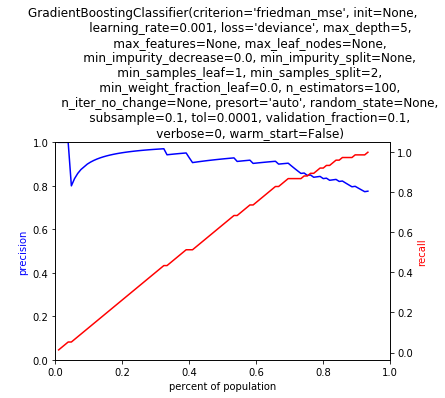

<Figure size 432x288 with 0 Axes>

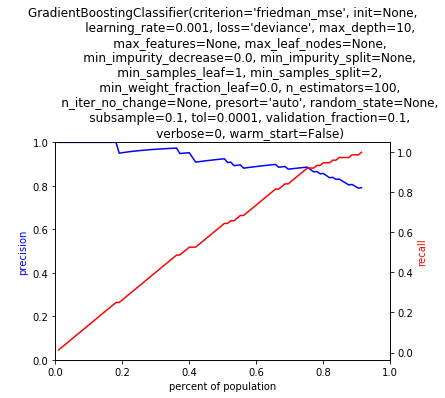

<Figure size 432x288 with 0 Axes>

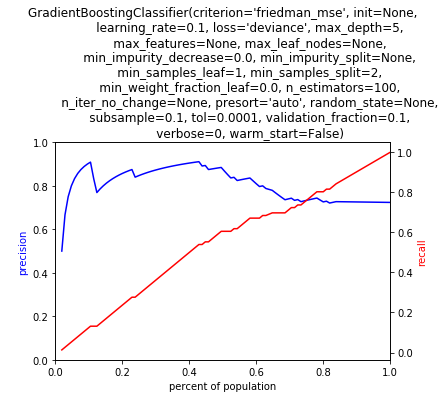

<Figure size 432x288 with 0 Axes>

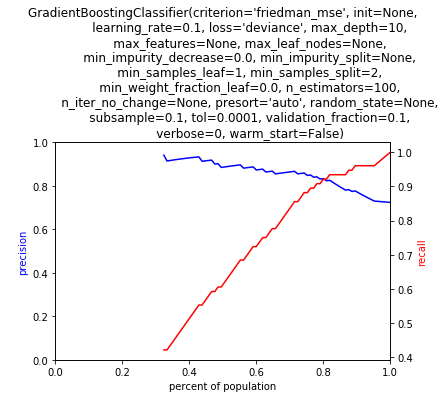

LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

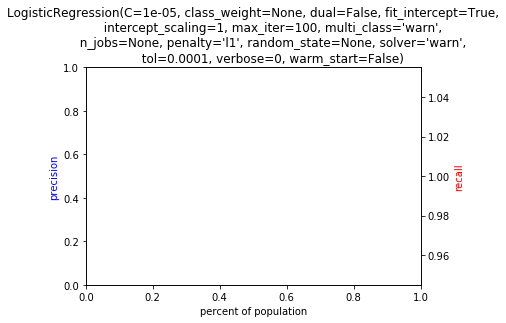

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

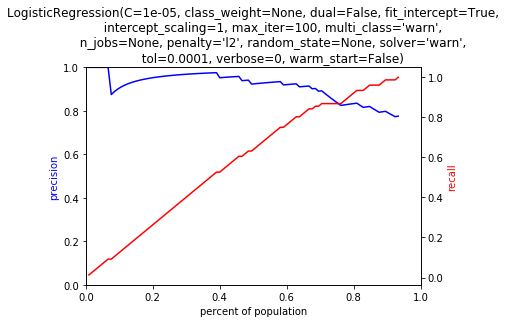

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

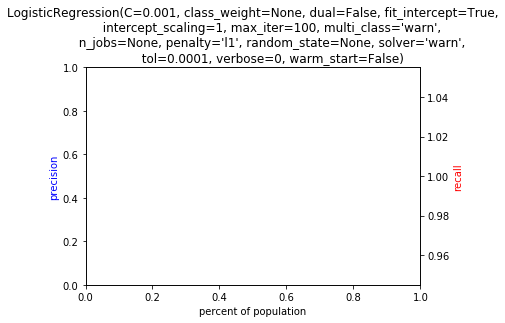

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

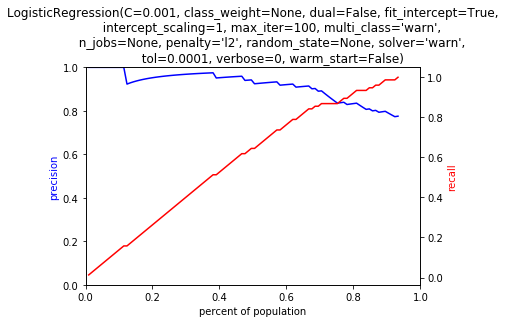

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

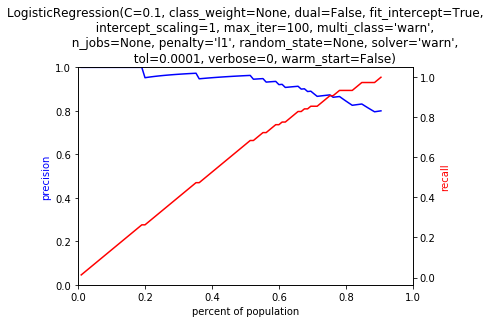

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

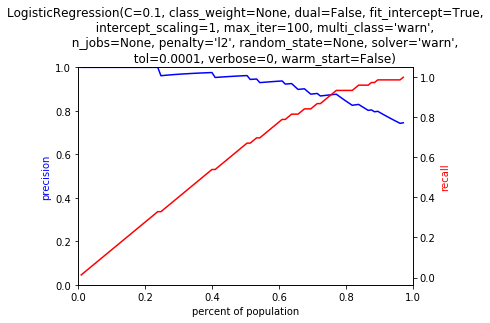

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

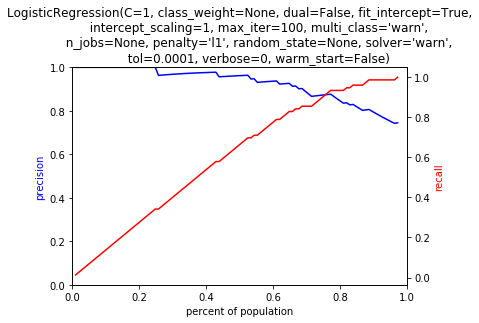

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

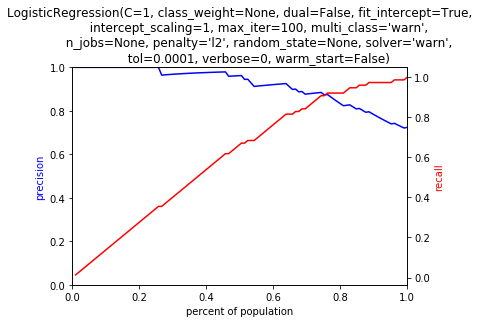

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

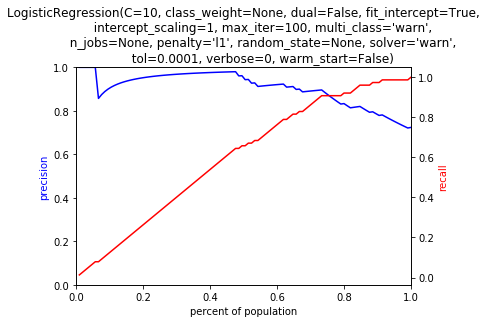

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

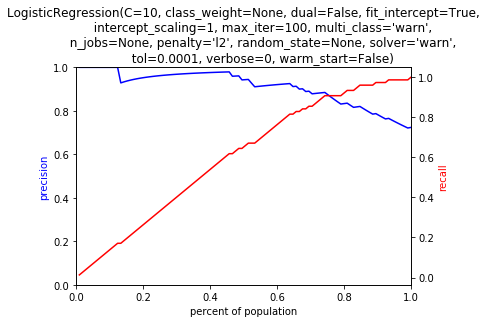

In [68]:
# define grid to use: test, small, large
grid_size = 'small'

    # define models to run
models_to_run=['GB', 'LR']

results_df = clf_loop(models_to_run, clfs, small_grid, X,Y)

GB


<Figure size 432x288 with 0 Axes>

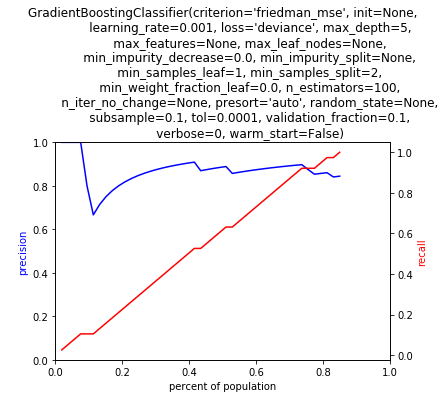

<Figure size 432x288 with 0 Axes>

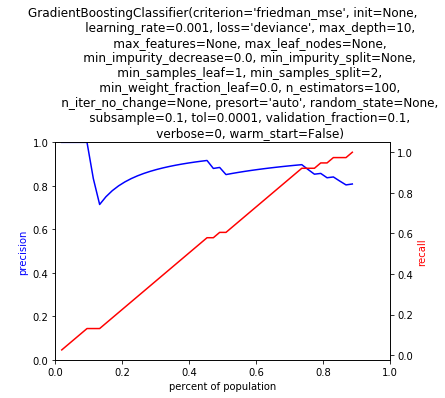

<Figure size 432x288 with 0 Axes>

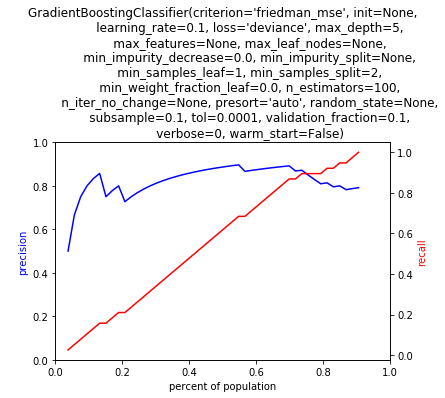

<Figure size 432x288 with 0 Axes>

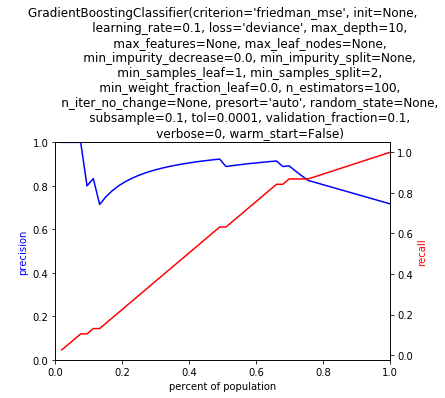

LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

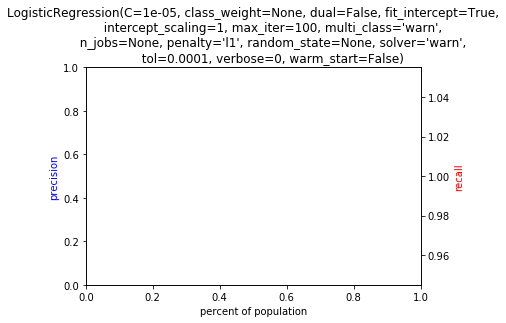

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

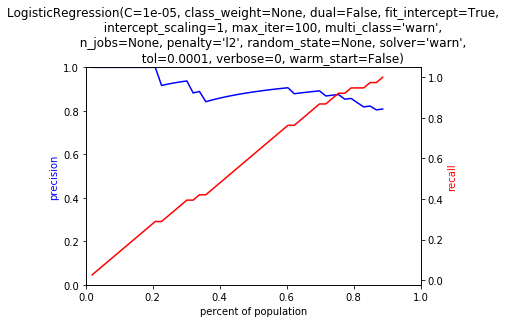

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

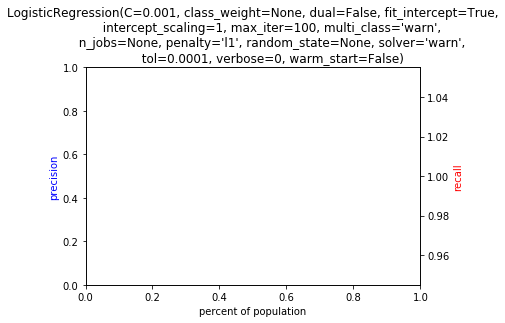

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

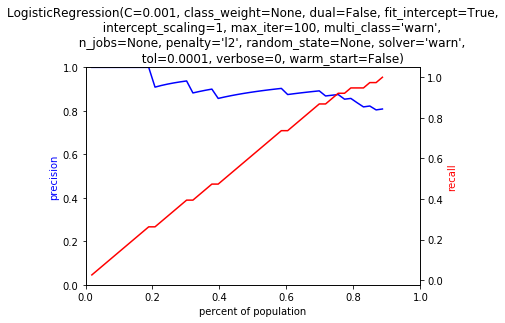

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

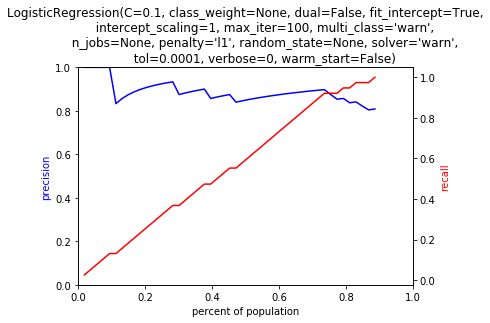

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

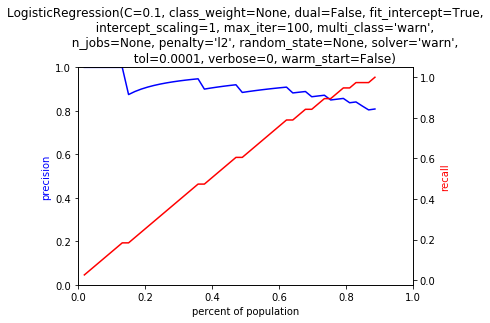

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

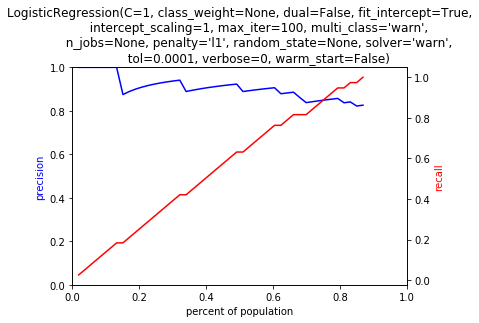

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

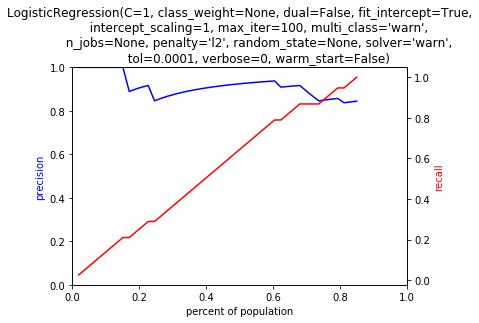

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

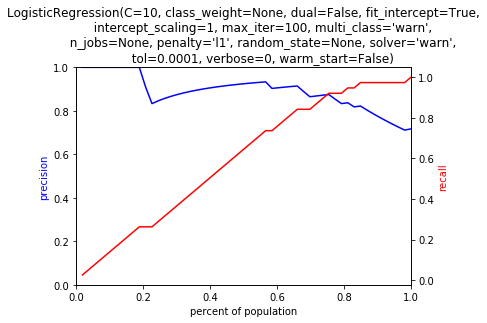

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

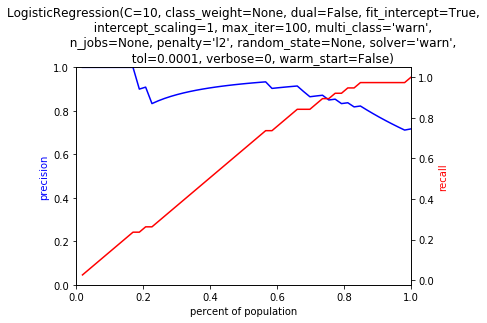

In [70]:
# define grid to use: test, small, large
grid_size = 'small'

    # define models to run
models_to_run=['GB', 'LR']

results_df_non_singleton = clf_loop(models_to_run, clfs, small_grid, X_non_singleton,Y_non_singleton)

In [71]:
results_df.sort_values('p_at_40',ascending=False).head(10)

,model_type,clf,parameters,p_at_20,p_at_40
4,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1e-05, 'penalty': 'l1'}",0.952381,0.976190
6,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.001, 'penalty': 'l1'}",0.952381,0.976190
9,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.1, 'penalty': 'l2'}",1.000000,0.976190
10,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1, 'penalty': 'l1'}",1.000000,0.976190
11,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1, 'penalty': 'l2'}",1.000000,0.976190
12,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 10, 'penalty': 'l1'}",0.952381,0.976190
13,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 10, 'penalty': 'l2'}",0.952381,0.976190
1,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.1}",0.952381,0.952381
5,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1e-05, 'penalty': 'l2'}",0.952381,0.952381
7,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.001, 'penalty': 'l2'}",0.952381,0.952381


In [72]:
results_df_non_singleton.sort_values('p_at_40',ascending=False).head(10)

,model_type,clf,parameters,p_at_20,p_at_40
4,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1e-05, 'penalty': 'l1'}",0.9,0.952381
6,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.001, 'penalty': 'l1'}",0.9,0.952381
0,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}",0.8,0.904762
1,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.1}",0.8,0.904762
3,GB,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n m...","{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.1}",0.8,0.904762
9,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 0.1, 'penalty': 'l2'}",0.9,0.904762
10,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1, 'penalty': 'l1'}",0.9,0.904762
11,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 1, 'penalty': 'l2'}",0.9,0.904762
12,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 10, 'penalty': 'l1'}",1.0,0.904762
13,LR,"LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, max_iter=100, multi_class='warn',\n n_jobs=None, penalty='l2', random_state=None, solver='warn',\n tol=0.0001, verbose=0...","{'C': 10, 'penalty': 'l2'}",0.9,0.904762


In [132]:
chosen_model = LogisticRegression(**{'C': 1, 'penalty': 'l1'})

In [133]:
fitted_model = chosen_model.fit(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [134]:
coefs = fitted_model.coef_.flatten().tolist()

named_coefs = zip(mapper.transformed_names_[:len(coefs)], coefs)

sorted_named_coefs = sorted(named_coefs, key=lambda tup: tup[1])

for name, coef in sorted_named_coefs:
    print(name,coef)

goodfaith_timestamps_total_seconds -0.6020943717697738
goodfaith_scores_var -0.41624544842462835
edit_wars -0.4161149044636349
goodfaith_scores_count_log -0.3788265087258371
pages_talk_count -0.18137537393000167
first_edit_ores_damaging -0.1437276887345065
goodfaith_scores_reg_intercept -0.05476698147528388
pages_unique_count -0.0391013129379096
first_edit_ores_goodfaith -0.003332409207570756
goodfaith_scores_min 0.0
goodfaith_scores_reg_slope 0.0
goodfaith_scores_count 0.0
goodfaith_timestamps_variance 0.0
goodfaith_timestamps_min 0.0
singleton_session 0.0
any_edit_ores_goodfaith 0.0
pages_namespace_count 0.05637375620531574
any_edit_ores_damaging 0.08214562271017666
pages_nonmain_count 0.12356322769625994
self_reverts 0.19636962126524524
goodfaith_scores_max 0.2391495217966604
goodfaith_timestamps_max 0.8644114077151747
goodfaith_scores_mean 1.0928604129757615


# Predict Today

In [2]:
reg_j= json.load(open('/home/paprika/workspace/wikilabels_data/saves/enwiki_registered_users_ge2_edits_20181123.json','r'))

col_names = reg_j['headers']
rows = reg_j['rows']

registered = pd.DataFrame.from_records(rows, columns=col_names)

In [3]:
def get_last_user_contribs_upto_date(user_id, end_date):
    user_q = session.get(action='query', list='usercontribs', ucuserids=user_id, ucstart=end_date)
    return user_q['query']['usercontribs']

In [4]:
registered['usercontribs'] = registered.apply(lambda row: get_last_user_contribs_upto_date(user_id=row['user_id'], end_date=row['NOW()']), axis=1)

In [23]:
dt.datetime.strptime('2018-11-21T23:55:48Z', "%Y-%m-%dT%H:%M:%SZ")

datetime.datetime(2018, 11, 21, 23, 55, 48)

In [25]:
[dt.datetime.strptime(e['timestamp'], "%Y-%m-%dT%H:%M:%SZ")  for e in registered['usercontribs'][0]]

[datetime.datetime(2018, 11, 21, 23, 55, 48),
 datetime.datetime(2018, 11, 21, 22, 46, 47),
 datetime.datetime(2018, 11, 21, 22, 44, 20),
 datetime.datetime(2018, 11, 21, 22, 42, 12)]

In [31]:
[{'page_id':e['pageid'],'page_ns':e['ns']} for e in registered['usercontribs'][0]]

[{'page_id': 53480675, 'page_ns': 0},
 {'page_id': 55993831, 'page_ns': 0},
 {'page_id': 53480675, 'page_ns': 0},
 {'page_id': 53480675, 'page_ns': 0}]

In [32]:
def num_reverts(revids):
    self_reverts = 0
    reverting_users = defaultdict(int)
    for rev_id in revids:
        try:
            _, reverted, reverted_to = mwreverts.api.check(
                session, rev_id, radius=2,  # most reverts within 5 edits
                window=48*60*60,  # 2 days
                rvprop={'user', 'ids'})  # Some properties we'll make use of
        except (RuntimeError, KeyError) as e:
            sys.stderr.write(str(e))
            continue
            
        if reverted is not None:
            
            reverting_user = reverted.reverting['user']
            reverting_users[reverting_user] += 1
            
            reverted_doc = [r for r in reverted.reverteds
                            if r['revid'] == rev_id][0]

            if 'user' not in reverted_doc or 'user' not in reverted.reverting:
                continue

            # self-reverts
            self_revert = \
                reverted_doc['user'] == reverting_user

            if self_revert:
                self_reverts += 1
    
    edit_war_users = [user for user, num_reverts in reverting_users.items() if num_reverts > 1]
    edit_wars = len(edit_war_users)
    
    return {'self_reverts': self_reverts, 'edit_wars':edit_wars}

def simp_lin_reg(vec,slope_intercept='slope'):
    if len(vec)==1:
        return 0
    else:
        x=list(range(len(vec)))
        reg = np.polyfit(x,vec,1)
        return reg[0] if slope_intercept == 'slope' else reg[1]
    
ores_string = 'https://ores.wikimedia.org/v3/scores/{context}/{revid}/{model}'
context = 'enwiki'
models = ('damaging', 'goodfaith')

def get_ores_data_dgf(rev_ids):
#     print(f'getting {len(rev_ids)} revs')
    ores_data = {}
    for model in ('damaging', 'goodfaith'):
        ores_data[model] = []
        for rev_id in rev_ids:
            ores_req = ores_string.format(context=context, revid=rev_id, model=model)
            ores_resp = requests.get(url=ores_req)
            json_data = ores_resp.json()
            try:
                ores_datum_raw = json_data[context]['scores'][str(rev_id)][model]['score']
                ores_datum = {'prediction':ores_datum_raw['prediction'],'prob_true':ores_datum_raw['probability']['true']}
                ores_data[model].append(ores_datum)
            except KeyError:
                ores_data[model].append(float('nan'))
    return ores_data

def total_seconds(timestamps):
    if len(timestamps)==1:
        return 60*60 # one hour
    else:
        delta = max(timestamps) - min(timestamps)
        return 60*60 + delta.seconds #one hour plus the difference
     
def fn_seconds(timestamps, fn):
    timestamps = sorted(timestamps)
    if len(timestamps)==1:
        return 0 #no variance
    else:
        deltas = []
        for i in range(len(timestamps)-1):
            deltas.append(timestamps[i+1]-timestamps[1])
        delta_seconds = [d.seconds for d in deltas]
        return fn(delta_seconds)

def make_features(df):
    df['rev_ids'] = df['usercontribs'].apply(lambda l: [e['revid'] for e in l])
    df['timestamps'] = df['usercontribs'].apply(lambda l: [dt.datetime.strptime(e['timestamp'], "%Y-%m-%dT%H:%M:%SZ")  for e in l])
    df['pages'] = df['usercontribs'].apply(lambda l: [{'page_id':e['pageid'],'page_ns':e['ns']} for e in l])
    df['ores_data'] = df['rev_ids'].apply(get_ores_data_dgf)
    df['revert_data'] = df['rev_ids'].apply(lambda x: num_reverts(x))

    df['self_reverts'] = df['revert_data'].apply(lambda d: d['self_reverts'])
    df['edit_wars'] = df['revert_data'].apply(lambda d: d['edit_wars'])
    df['damaging_scores'] = df['ores_data'].apply(lambda d: [e['prob_true'] for e in d['damaging'] if isinstance(e, dict)])
    df['goodfaith_scores'] = df['ores_data'].apply(lambda d: [e['prob_true'] for e in d['goodfaith'] if isinstance(e, dict)])
    df['damaging_predictions'] = df['ores_data'].apply(lambda d: [e['prediction'] for e in d['damaging'] if isinstance(e, dict)])
    df['goodfaith_predictions'] = df['ores_data'].apply(lambda d: [e['prediction'] for e in d['goodfaith'] if isinstance(e, dict)])
    
    df['goodfaith_scores_mean'] = df['goodfaith_scores'].apply(np.mean)
    df['goodfaith_scores_var'] = df['goodfaith_scores'].apply(np.var)
    df['goodfaith_scores_max'] = df['goodfaith_scores'].apply(max)
    df['goodfaith_scores_min'] = df['goodfaith_scores'].apply(min)
    df['goodfaith_scores_reg_slope'] = df['goodfaith_scores'].apply(lambda v: simp_lin_reg(v,'slope'))
    df['goodfaith_scores_reg_intercept'] = df['goodfaith_scores'].apply(lambda v: simp_lin_reg(v,'intercept'))
    df['goodfaith_scores_count'] = df['goodfaith_scores'].apply(len)
    df['goodfaith_scores_count_log'] = df['goodfaith_scores'].apply(lambda v: np.log(len(v)))

    df['damaging_timestamps_total_seconds'] = df['timestamps'].apply(total_seconds)
    df['damaging_timestamps_variance'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.var))
    df['damaging_timestamps_min'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.min))
    df['damaging_timestamps_max'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.max))

    df['goodfaith_timestamps_total_seconds'] = df['timestamps'].apply(total_seconds)
    df['goodfaith_timestamps_variance'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.var))
    df['goodfaith_timestamps_min'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.min))
    df['goodfaith_timestamps_max'] = df['timestamps'].apply(lambda t: fn_seconds(t, np.max))

    df['pages_unique_count'] = df['pages'].apply(lambda plist: len(set([p['page_id'] for p in plist])))
    df['pages_namespace_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist])))
    df['pages_nonmain_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist if p['page_ns']!=0])))
    df['pages_talk_count'] = df['pages'].apply(lambda plist: len(set([p['page_ns'] for p in plist if p['page_ns']%2==1])))

    df['singleton_session'] = df['rev_ids'].apply(lambda rev_ids: len(rev_ids)==1)

    df['first_edit_ores_goodfaith'] = df['goodfaith_predictions'].apply(lambda predictions: predictions[0])
    df['first_edit_ores_damaging'] = df['damaging_predictions'].apply(lambda predictions: predictions[0])
    df['any_edit_ores_goodfaith'] = df['goodfaith_predictions'].apply(lambda predictions: any(predictions))
    df['any_edit_ores_damaging'] = df['damaging_predictions'].apply(lambda predictions: any(predictions))
    return df


In [33]:
registered_s = registered.iloc[:1]

In [35]:
%%capture
registered_s_featured = make_features(registered_s)

In [36]:
registered_s_featured

,user_id,user_name,user_registration,user_editcount,NOW(),usercontribs,rev_ids,timestamps,pages,ores_data,...,goodfaith_timestamps_max,pages_unique_count,pages_namespace_count,pages_nonmain_count,pages_talk_count,singleton_session,first_edit_ores_goodfaith,first_edit_ores_damaging,any_edit_ores_goodfaith,any_edit_ores_damaging
0,35198440,Jessicamaehubbard,20181121223814,4,2018-11-23T22:37:00,"[{'userid': 35198440, 'user': 'Jessicamaehubbard', 'pageid': 53480675, 'revid': 870038201, 'parentid': 870029399, 'ns': 0, 'title': 'The Badger (newspaper)', 'timestamp': '2018-11-21T23:55:48Z', 'top': '', 'comment': '', 'size': 4990}, {'userid':...","[870038201, 870029708, 870029399, 870029110]","[2018-11-21 23:55:48, 2018-11-21 22:46:47, 2018-11-21 22:44:20, 2018-11-21 22:42:12]","[{'page_id': 53480675, 'page_ns': 0}, {'page_id': 55993831, 'page_ns': 0}, {'page_id': 53480675, 'page_ns': 0}, {'page_id': 53480675, 'page_ns': 0}]","{'damaging': [{'prediction': False, 'prob_true': 0.2368680919246324}, {'prediction': False, 'prob_true': 0.3004932919727388}, {'prediction': False, 'prob_true': 0.34138625409388956}, {'prediction': False, 'prob_true': 0.36456977621083564}], 'good...",...,4288,2,1,0,0,False,True,False,True,False
